In [44]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import re
import cv2

from keras.models import Sequential
from keras.layers import Dense

import keras
from keras import losses
from keras.datasets import mnist
from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras import backend as K
from keras.optimizers import Adam

from keras.models import model_from_json

In [45]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[i:i+w, j:j+h]
            else:
                im_patch = im[i:i+w, j:j+h, :]
            list_patches.append(im_patch)
    return list_patches

def reflectBorder(im) :
    bordersize = patch_size*2
    border=cv2.copyMakeBorder(im, top=bordersize, bottom=bordersize, left=bordersize, right=bordersize, borderType= cv2.BORDER_REFLECT )
    return border

In [46]:
# Loaded a set of images
root_dir = "data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(30, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 30 # Only use 10 images for training

Loading 30 images
satImage_092.png
Loading 30 images
satImage_092.png


Image size = 400,400


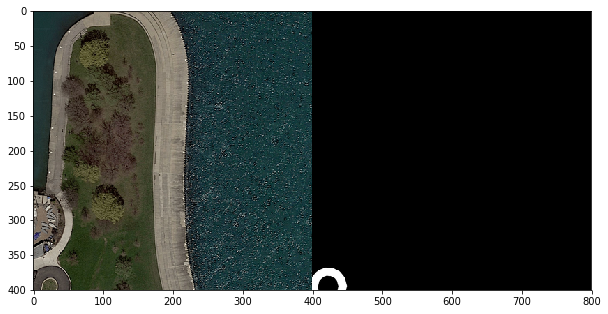

In [47]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [48]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [49]:
foreground_threshold = 0.25

# Given an input image 
def image_to_inputs(img, gt):
    rows, cols, _ = img.shape
    
    patches = [
        (
            img[i-2*patch_size:i+3*patch_size, j-2*patch_size:j+3*patch_size, :],
            gt[i:i+patch_size, j:j+patch_size]
        )
        for i in range(2*patch_size, rows - 3*patch_size+1, patch_size)
        for j in range(2*patch_size, cols - 3*patch_size+1, patch_size)
    ]

    return patches

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

In [50]:
all_inputs = [inputs for i in range(n) for inputs, _ in image_to_inputs(reflectBorder(imgs[i]), reflectBorder(gt_imgs[i]))]
all_gt = [value_to_class(np.mean(gt)) for i in range(n) for _, gt in image_to_inputs(reflectBorder(imgs[i]), reflectBorder(gt_imgs[i]))]
X = np.asarray(all_inputs)
y = np.asarray(all_gt)
y = np.reshape(y, (-1,1))
print(X.shape)
print(y.shape)

(18750, 80, 80, 3)
(18750, 1)


In [51]:
def train_test_split(X, y, test_ratio=0.8, seed=42):
    n = len(X)
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    limit = int(test_ratio * n)
    X_train, y_train = X[idxs[:limit]], y[idxs[:limit]]
    X_test, y_test = X[idxs[limit:]], y[idxs[limit:]]
    return X_train, X_test, y_train, y_test

In [52]:
batch_size = 32
#num_classes = 2
num_filters_1 = 10
num_filters_2 = 30
num_filters_3 = 50
num_filters_4 = 70
epochs = 20

# the data, shuffled and split between train and test sets
x_train, x_test, y_train, y_test  = train_test_split(X, y, 0.8)

In [53]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, 5*patch_size, 5*patch_size)
    x_test = x_test.reshape(x_test.shape[0], 3, 5*patch_size, 5*patch_size)
    input_shape = (3, img_rows, img_cols)
else:
    # We should be here
    x_train = x_train.reshape(x_train.shape[0], 5*patch_size, 5*patch_size, 3)
    x_test = x_test.reshape(x_test.shape[0], 5*patch_size, 5*patch_size, 3)
    input_shape = (5*patch_size, 5*patch_size, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Already scaled
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('input shape', input_shape)

x_train shape: (15000, 80, 80, 3)
15000 train samples
3750 test samples
input shape (80, 80, 3)


In [54]:
model = Sequential()
model.add(Conv2D(num_filters_1, kernel_size=(4, 4), # kernel 5,5 or 4,4
                 #activation='relu',
                 input_shape=input_shape))

model.add(LeakyReLU(alpha=0.1))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Conv2D(num_filters_2, kernel_size=(4,4),
                 #activation='relu'
                )) # kernel 4,4 

model.add(LeakyReLU(alpha=0.1))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Conv2D(num_filters_3, kernel_size=(4,4),
                 #activation='relu'
                )) # kernel 4,4 

model.add(LeakyReLU(alpha=0.1))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Conv2D(num_filters_4, kernel_size=(4,4),
                 #activation='relu'
                )) # kernel 4,4 

model.add(LeakyReLU(alpha=0.1))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Flatten())

#model.add(Dense(400, activation='sigmoid'))

model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-3), # 'rmsprop'
              metrics=['accuracy'])


In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 77, 77, 10)        490       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 77, 77, 10)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 38, 38, 10)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 38, 38, 10)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 35, 35, 30)        4830      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 35, 35, 30)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 17, 17, 30)        0         
__________

In [ ]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          shuffle=True,
          validation_data=(x_test, y_test))

Train on 15000 samples, validate on 3750 samples
Epoch 1/20
15000/15000 [==============================] - 33s - loss: 0.5076 - acc: 0.7354 - val_loss: 0.4653 - val_acc: 0.7331
Epoch 2/20
15000/15000 [==============================] - 33s - loss: 0.4297 - acc: 0.7767 - val_loss: 0.3842 - val_acc: 0.8197
Epoch 3/20
15000/15000 [==============================] - 33s - loss: 0.3441 - acc: 0.8436 - val_loss: 0.3137 - val_acc: 0.8619
Epoch 4/20
15000/15000 [==============================] - 34s - loss: 0.2879 - acc: 0.8719 - val_loss: 0.2621 - val_acc: 0.8909
Epoch 5/20
15000/15000 [==============================] - 33s - loss: 0.2436 - acc: 0.8949 - val_loss: 0.2435 - val_acc: 0.8928
Epoch 6/20
15000/15000 [==============================] - 33s - loss: 0.2139 - acc: 0.9081 - val_loss: 0.2069 - val_acc: 0.9147
Epoch 7/20
15000/15000 [==============================] - 33s - loss: 0.1947 - acc: 0.9185 - val_loss: 0.1910 - val_acc: 0.9184
Epoch 8/20
15000/15000 [==============================]

In [28]:
score = model.evaluate(x_test, y_test, verbose=1, batch_size=batch_size)
print('Test loss:', score[0])
print('Test acc:', score[1])

8000/8000 [==============================] - 89s    
Test loss: 0.287717226207
Test acc: 0.91325


In [29]:
img_idx  = 80
pred_image = [inputs for inputs, _ in image_to_inputs(imgs[img_idx], gt_imgs[img_idx])]
predictions = model.predict(np.asarray(pred_image), verbose=1)

400/400 [==============================] - 4s     


In [30]:
print('model ouput size: ', predictions.shape)
predictions = predictions.reshape((20, 20))
print('new size: ', predictions.shape)
predictions_aug = np.zeros((25, 25))
predictions_aug[2:22, 2:22] = predictions
predictions_aug.shape

model ouput size:  (400, 1)
new size:  (20, 20)


(25, 25)

In [31]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[i:i+w, j:j+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

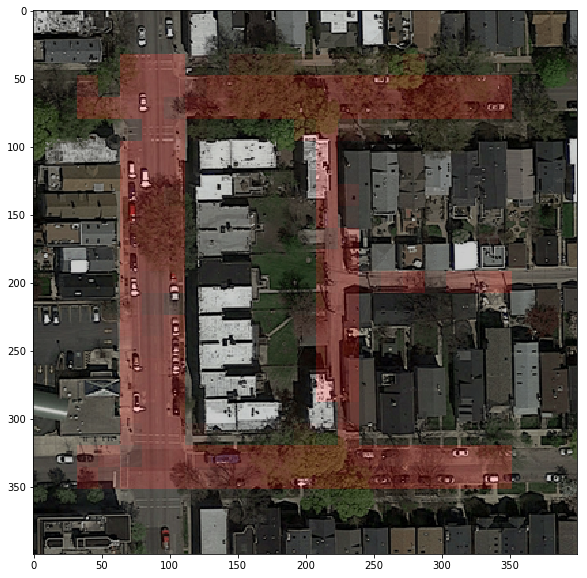

In [32]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, [elem for lst in predictions_aug for elem in lst])
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)


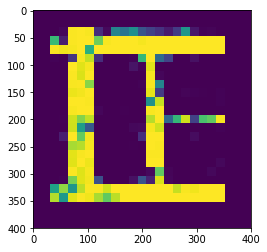

In [33]:
plt.imshow(predicted_im)

In [43]:
# save the model and the weights to files
model_json = model.to_json()
f = open('savedModels/model_6', 'w')
f.write(model_json)
f.close()
model.save_weights('savedModels/weights_6')



In [17]:
# load model to test
fm = open('/Users/VIPu/DATA/EPFL/Sem9/CS433_MachineLearning/projet2/epfml17-segmentation/savedModels/model_2')
model_2 = model_from_json(fm.read())
model_2.load_weights('/Users/VIPu/DATA/EPFL/Sem9/CS433_MachineLearning/projet2/epfml17-segmentation/savedModels/weights_2', by_name=False)
fm.close()

model_2.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-3),#'rmsprop',
              metrics=['accuracy'])

model_2.evaluate(x_test, y_test, verbose=1, batch_size=batch_size)

8000/8000 [==============================] - 95s    


[0.28771722620725632, 0.91325000000000001]